Play the code above to generate faces of Donald Trump speaking.
You can change de variable images when calling the function test to generate a different number of faces.
The first image you will see is the output of the CNN trained using MSE. The second image is the final output of the system.

////////////IMPORTANT\\\\\\\\\\\\
Please restart the kernel (next to the STOP bottom) each time you RUN the code below.

  [TL] InputLayer  generator_MSE/in_audio_features_extractor: (?, 35, 11, 1)
  [TL] Conv2dLayer generator_MSE/AudioFeatures/conv1: shape:[3, 3, 1, 64] strides:[1, 1, 1, 1] pad:SAME act:lrelu1
  [TL] Conv2dLayer generator_MSE/AudioFeatures/conv2: shape:[3, 3, 64, 128] strides:[1, 1, 1, 1] pad:SAME act:lrelu1
  [TL] PoolLayer   generator_MSE/AudioFeatures/pool1: ksize:[1, 2, 2, 1] strides:[1, 2, 1, 1] padding:SAME pool:avg_pool
  [TL] Conv2dLayer generator_MSE/AudioFeatures/conv3: shape:[3, 3, 128, 256] strides:[1, 1, 1, 1] pad:SAME act:lrelu1
  [TL] Conv2dLayer generator_MSE/AudioFeatures/conv4: shape:[3, 3, 256, 512] strides:[1, 1, 1, 1] pad:SAME act:lrelu1
  [TL] PoolLayer   generator_MSE/AudioFeatures/pool2: ksize:[1, 2, 2, 1] strides:[1, 2, 1, 1] padding:SAME pool:avg_pool
  [TL] FlattenLayer generator_MSE/AudioFeatures/flatten: 50688
  [TL] DenseLayer  generator_MSE/AudioFeatures/dense1: 512 lrelu1
  [TL] DenseLayer  generator_MSE/AudioFeatures/dense2: 256 lrelu1
  [TL] DenseLayer 

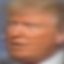

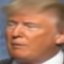

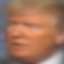

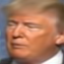

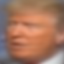

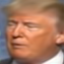

In [1]:
import tensorlayer as tl
import os
from tensorlayer.layers import *
import argparse
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

def lrelu1(x, name="lrelu1"):
    return tf.maximum(x, 0.25*x)

def denorm_img(norm):
    return tf.clip_by_value((norm + 1)*127.5, 0, 255)


def norm_img(image):
    image = image/127.5 - 1.
    return image


def get_items():
    audio_list = [os.path.join("/storage/dataset_videos/cropped_videos/outputb", f) 
                  for f in os.listdir("/storage/dataset_videos/cropped_videos/outputb")
                  if os.path.isfile(os.path.join("/storage/dataset_videos/cropped_videos/outputb", f)) and
                  '_MFCC2_' in f and 'eMLs9XkrVj0' in f]
    return audio_list

def generator_deblurring(gen_in, reuse, hidden_number=64, kernel=3):
    w_init = tf.random_normal_initializer(stddev=0.02)

    with tf.variable_scope("generator", reuse=reuse):
        tl.layers.set_name_reuse(reuse)

        # DECODER BEGINS
        x = InputLayer(gen_in, name="in")
        x = Conv2dLayer(x, shape=[kernel, kernel, 3, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv0')
        input_1_skip = x
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv1')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv2')
        x = ElementwiseLayer([x, input_1_skip], tf.add, name='Generator/skip1')

        input_2_skip = x
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv3')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv4')
        x = ElementwiseLayer([x, input_2_skip], tf.add, name='Generator/skip2')

        input_3_skip = x
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv5')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv6')
        x = ElementwiseLayer([x, input_3_skip], tf.add, name='Generator/skip3')

        input_4_skip = x
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1],
                        padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv7')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator/conv8')
        x = ElementwiseLayer([x, input_4_skip], tf.add, name='Generator/skip4')

        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, 3], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, name='Generator/convLAST')

        return x


def generator_MSE(input_audio, reuse, hidden_number=64, kernel=3):
    w_init = tf.random_normal_initializer(stddev=0.02)

    with tf.variable_scope("generator_MSE", reuse=reuse):
        tl.layers.set_name_reuse(reuse)

        # EXTRACT AUDIO FEATURES
        x = InputLayer(input_audio, name="in_audio_features_extractor") #[batch_size, height, width, 1]
        x = Conv2dLayer(x, shape=[kernel, kernel, 1, 64], strides=[1, 1, 1, 1], padding='SAME', W_init=w_init,
                        act=lrelu1, name='AudioFeatures/conv1')
        x = Conv2dLayer(x, shape=[kernel, kernel, 64, 128], strides=[1, 1, 1, 1], padding='SAME', W_init=w_init,
                        act=lrelu1, name='AudioFeatures/conv2')
        x = PoolLayer(x, strides=[1, 2, 1, 1], pool=tf.nn.avg_pool, name='AudioFeatures/pool1')
        x = Conv2dLayer(x, shape=[kernel, kernel, 128, 256], strides=[1, 1, 1, 1], padding='SAME', W_init=w_init,
                        act=lrelu1, name='AudioFeatures/conv3')
        x = Conv2dLayer(x, shape=[kernel, kernel, 256, 512], strides=[1, 1, 1, 1], padding='SAME', W_init=w_init,
                        act=lrelu1, name='AudioFeatures/conv4')
        x = PoolLayer(x, strides=[1, 2, 1, 1], pool=tf.nn.avg_pool, name='AudioFeatures/pool2')
        x = FlattenLayer(x, name='AudioFeatures/flatten')
        x = DenseLayer(x, n_units=512, name='AudioFeatures/dense1', act=lrelu1)
        x = DenseLayer(x, n_units=256, name='AudioFeatures/dense2', act=lrelu1) #[batch_size, 256]

        # DECODER BEGINS
        x = DenseLayer(x, n_units=8*8*hidden_number, name='Generator_MSE/dense2')
        arguments = {'shape': [-1, 8, 8, hidden_number], 'name': 'Generator_MSE/reshape1'}
        x = LambdaLayer(x, fn=tf.reshape, fn_args=arguments)
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1,1,1,1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu,name='Generator_MSE/conv1')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu,name='Generator_MSE/conv2')
        x = UpSampling2dLayer(x, size=[2, 2], is_scale=True, method=1, name='Generator_MSE/UpSampling1') # method= 1 NN

        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu,name='Generator_MSE/conv3')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator_MSE/conv4')
        x = UpSampling2dLayer(x, size=[2, 2], is_scale=True, method=1, name='Encoder_MSE/UpSampling2')  # method= 1 NN

        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu,name='Generator_MSE/conv5')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu,name='Generator_MSE/conv6')
        x = UpSampling2dLayer(x, size=[2, 2], is_scale=True, method=1, name='Generator_MSE/UpSampling3')  # method= 1 NN

        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1],
                        padding='SAME',
                        W_init=w_init,act=tf.nn.elu, name='Generator_MSE/conv7')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, hidden_number], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, act=tf.nn.elu, name='Generator_MSE/conv8')
        x = Conv2dLayer(x, shape=[kernel, kernel, hidden_number, 3], strides=[1, 1, 1, 1], padding='SAME',
                        W_init=w_init, name='Generator_MSE/convLAST')

        return x
def test(images, reuse = False):
    
    # ##========================== DEFINE MODEL ============================###
    MSE_graph = tf.Graph()
    with MSE_graph.as_default():
        audio = tf.placeholder('float32', [None, 35, 11, 1], name='t_audio_input_generator')
        model = generator_MSE(input_audio=audio, reuse=reuse)
        output_gen_MSE = denorm_img(model.outputs)  # Denormalization MSE image

    adv_graph = tf.Graph()
    with adv_graph.as_default():
        image_MSE = tf.placeholder('float32', [None, 64, 64, 3], name='t_image_input_MSE')
        adversary = generator_deblurring(gen_in=image_MSE, reuse=reuse)
        output_gen_deblurring = denorm_img(adversary.outputs)  # Denormalization HQ image
    
    adv_sess = tf.Session(graph=adv_graph)
    MSE_sess = tf.Session(graph=MSE_graph)
    
    with MSE_sess.as_default():
        with MSE_graph.as_default():
            model_saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator_MSE"))
            model_ckpt = tf.train.get_checkpoint_state("/storage/checkpoints")
            model_saver.restore(MSE_sess, model_ckpt.model_checkpoint_path)
            audio_MFCC = np.empty([images, 35, 11, 1])
            audio_list = get_items()
            index = random.randint(0, len(audio_list))
            cont = 0
            for input_audio in audio_list[index:index + images]:
                input_audio = np.load(input_audio)
                input_audio = np.asarray(input_audio, dtype=float)
                audio_MFCC[cont] = input_audio[:, :, np.newaxis]
                cont+=1
            output_image_MSE = MSE_sess.run(output_gen_MSE, feed_dict={audio: audio_MFCC})

    with adv_sess.as_default():
        with adv_graph.as_default():
            adv_saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="generator"))
            adv_ckpt = tf.train.get_checkpoint_state("/storage/checkpoints_deblurred_MSE")
            adv_saver.restore(adv_sess, adv_ckpt.model_checkpoint_path)
            output_image_HQ = adv_sess.run(output_gen_deblurring, feed_dict={image_MSE: norm_img(output_image_MSE)})

    return output_image_MSE, output_image_HQ
            
if __name__ == '__main__':
    output_image_MSE, output_image_HQ = test(images = 3)
    for ima_MSE, ima_HQ in zip(output_image_MSE, output_image_HQ):
        ima_MSE = Image.fromarray(ima_MSE.astype(np.uint8), 'RGB')
        display(ima_MSE)
        ima_HQ = Image.fromarray(ima_HQ.astype(np.uint8), 'RGB')
        display(ima_HQ)